In [22]:
###Pandas Libraries
import pandas as pd
import datetime
import time

#Dash Libraries
#import dash  # USE THIS IF RUNNING ON SERVER
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
from jupyter_dash import JupyterDash # USE THIS IF RUNNING ON JUPYTER
import numpy as np

##  TABLE MANIPULATION CODE

In [586]:
#*********                     FUNCTION RUNS ALL OF THE DATA MANIPULATION CODE
#start = time.time()  ## TIMER FUNCTION

##### CLEAN TRANSFERS DATA
df = pd.read_csv('transfers.csv')
df = df.rename(columns = {'Start_Bed_Dttm':'Start', 'End_Bed_Dttm':'End'})
df = df.drop(columns=['Transfers', 'Bed_Code', 'Full Flow Code', 'Current Flow Code', '1st Level','PASID'])
date_cols = ['Start', 'End']
df[date_cols] = df[date_cols].apply(pd.to_datetime, format='%d/%m/%y %H:%M', errors='raise')

###### CLEAN EVENTS AND PUBLIC HOLIDAY DATA
events_df = pd.read_csv('exception_dates.csv')
events_df = events_df.rename(columns = {'DATE':'Date', 'EVENT':'Event'})
events_df['Date'] = events_df['Date'].apply(pd.to_datetime, format='%d/%m/%Y', errors='coerce')
events_df['Date'] = events_df['Date'].dt.date

####### ADD HIERARICAL DATA
#DAY OF THE WEEK
df['Day'] = df.Start.dt.weekday
dayconv = {'Day_Type':['Weekday','Weekday','Weekday','Weekday','Weekday','Weekend','Weekend'],
                  'Day': [0,1,2,3,4,5,6]}
dayconv_df = pd.DataFrame.from_dict(dayconv)
df = pd.merge(df, dayconv_df, how='left', on='Day')
#df.drop(columns='Day')
#MONTH NAME
df['Month'] = df.Start.dt.month_name()
#YEAR
df['Year'] = df.Start.dt.year
#HOUR OF DAY
df['Hour_of_Day'] = df.Start.dt.hour
#Convert Hour of Day to time period
timeconv = {'Admission_Period':['Planned','Unplanned','Unplanned','Unplanned','Unplanned','Planned',
                                 'Planned','Planned','Planned','Unplanned','Unplanned','Unplanned',
                                 'Unplanned','Unplanned','Unplanned','Unplanned','Unplanned','Planned',
                                 'Planned','Planned','Planned','Planned','Planned','Planned'],
                  'Hour_of_Day': [0,1,2,3,4,5,
                                 6,7,8,9,10,11,
                                 12,13,14,15,16,17,
                                 18,19,20,21,22,23]}
timeconv_df = pd.DataFrame.from_dict(timeconv)
df = pd.merge(df, timeconv_df, how='left', on='Hour_of_Day')
df.drop(columns='Hour_of_Day')
#DATE WITHOUT TIME
df['Date'] = df.Start.dt.date
#EVENTS
df = pd.merge(df, events_df, how='left', on='Date')
df['Event'] = df['Event'].fillna('NONE')
event_activity = {'Event_Activity':['High','High','High','Low','Normal','Normal','Low','Low'],
                 'Event':['AFTERXMAS','B4EASTER','BEFOREXMAS','EASTER','NONE','SCHOOL','XMAS','PUBLIC']}
event_activity_df = pd.DataFrame.from_dict(event_activity)
df = pd.merge(df, event_activity_df, how='left', on='Event')
df.drop(columns='Event')

####### RENAME WARD_CODES THAT ARE NOT PART OF THE IDEAL PATH AND DELETE DUPLICATES
orig_df = df #Saves a copy of the crruent state of the dataframe (used to query the original unmodified dataframe)
#CA, CL & HE Codes are converted to MT
df.loc[(df['Ward_Code'] == 'CA') | (df['Ward_Code'] == 'CL') | (df['Ward_Code'] == 'HE') , 'Ward_Code'] = 'MT' #Ward Code CA, CL, HE = MT
# Drop DPS from the new dataset
index_names = df.loc[(df['Ward_Code'] == 'DPS') | ((df['Ward_Code'] == 'ON'))].index
df = df.drop(index_names)
# PATIENT PREVIOUS FLOW PATH
df = df.sort_values(['Link', 'Start'])
def prev_flow(df, n):
    for i in range(n, 0, -1):
        df.Prev_Flow = np.where(df.Link == df.Link.shift(i), 
                 df.Prev_Flow + '-' + df.Ward_Code.shift(i), df.Prev_Flow)
    return df.Prev_Flow
df['Prev_Flow'] = 'IN'
df['Prev_Flow'] = prev_flow(df, 7)
# NEXT WARD FOR PATIENT
df['Next_Ward'] = np.where(df.Link == df.Link.shift(-1), df.Ward_Code.shift(-1),'OUT')
# REMOVE DUPLICATE ENTRIES CAUSED BY REPLACING WARD CODES WITH IDEAL WARD_CODES
duplicate_df = df.loc[(df.Ward_Code == df.Next_Ward)|(df.Ward_Code == df.Prev_Flow.str[-2:])|(df.Ward_Code == df.Prev_Flow.str[-3:])]
duplicate_grp_df = duplicate_df.groupby(['Link', 'Ward_Code'])
#get the min start date and max end date from the grouped results
df['min_start'] = duplicate_grp_df['Start'].transform('min')
df['max_end'] = duplicate_grp_df['End'].transform('max')
#Drop the Original start & end dates & rename the new calculated start & end
df['Start'] = np.where(df.min_start.notnull(), df.min_start, df.Start)
df['End'] = np.where(df.max_end.notnull(), df.max_end, df.End)
df = df.sort_values(['Link', 'Start'], ascending = True)
df= df.drop_duplicates(keep='first', subset=['Link', 'Ward_Code','Start'])
#dropped_df = df.loc[(df.Ward_Code == df.Next_Ward)|(df.Ward_Code == df.Prev_Flow.str[-2:])].drop_duplicates(keep='first', subset=['Link', 'Ward_Code','Start'])
#df = df[~df.index.isin(dropped_df.index)]
df = df.drop(columns=['min_start', 'max_end'])

######## CALCULATE THE CRITICAL VARIABLES FOR THE SIMULATION
# CALCULATE LENGTH OF STAY
duration = df['End'] - df['Start']
df['LOS'] = (duration.dt.days * 24) + (duration.dt.seconds / (60*60)) # converts day & seconds fields to hours
df['LOS'] = df['LOS'].round(2)
# DETERMINE PREVIOUS PATIENT FLOW PATH
df = df.sort_values(['Link', 'Start'])
def prev_flow(df, n):
    for i in range(n, 0, -1):
        df.Prev_Flow = np.where(df.Link == df.Link.shift(i), 
                 df.Prev_Flow + '-' + df.Ward_Code.shift(i), df.Prev_Flow)
    return df.Prev_Flow
df['Prev_Flow'] = 'IN'
df['Prev_Flow'] = prev_flow(df, 7)
# DETERMINE NEXT WARD FOR PATIENT
df['Next_Ward'] = np.where(df.Link == df.Link.shift(-1), df.Ward_Code.shift(-1),'OUT')
# SHOW ALL OF THE FLOW CODES FOR PATIENT
df['Full_Flow_Code'] = 1
df['Full_Flow_Code'] = df.groupby(['Link'])['Ward_Code'].transform(lambda x: '-'.join(x))
df['Full_Flow_Code'] ='IN' + '-' + df.Full_Flow_Code + '-' + 'OUT'
#INTERARRIVAL TIME
df = df.sort_values('Start')
temp_df = df.loc[df.Prev_Flow == 'IN', 'Start'] - df.loc[df.Prev_Flow == 'IN', 'Start'].shift(1)
df['Int_Arrival'] = pd.to_numeric(temp_df.dt.days*24 + temp_df.dt.seconds / (60*60))
df['Int_Arrival'] = df.Int_Arrival.round(2)
ideal_df = df #Save a copy of the dataset to the ideal dataframe

######## CREATE SUMMARY TABLE FOR INTERARRIVAL TIME
df = ideal_df
df = df.loc[df.Int_Arrival.notnull(),:]
df = df.drop(columns=['Link','Ward_Code','Day', 'Month','Year','Hour_of_Day', 'Date','Event','LOS', 'Prev_Flow', 'Next_Ward','Full_Flow_Code',  'Start', 'End'])
#create bins for all of counts
df['Int_Arrival_Bins'] = pd.cut(x=df['Int_Arrival'], bins=[0,9,19,29,49,59,69,79,89,99,109])
#temp_df.Int_Arrival.max()  #used to find the biggest number
df = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period','Int_Arrival_Bins']).count()
df = df.reset_index()
df['Total_Counts'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period']).transform('sum')
df['Arrival_Probability'] = df.Int_Arrival / df.Total_Counts
df['Arrival_Probability'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period']).cumsum()['Arrival_Probability']
df = df.dropna()
df = df.drop(columns = ['Int_Arrival', 'Total_Counts'])
df = df.set_index(['Event_Activity', 'Day_Type', 'Admission_Period','Int_Arrival_Bins'])
arrivalsum_df = df 

######## CREATE MODIFIER FOR ARRIVAL INTERVAL YEAR TO YEAR & MONTH TO MONTH
df = ideal_df
overall_mean = df.groupby(['Prev_Flow']).Int_Arrival.mean().loc['IN']
df = df.groupby(['Prev_Flow','Year']).Int_Arrival.mean().loc['IN'].reset_index()
df['Int_Arrival'] = df.Int_Arrival / overall_mean
annual_plot_df = df
min_date = df.Year[0]
max_date = df.Year[7]
min_date_modifier = df.Int_Arrival[0]
max_date_modifier = df.Int_Arrival[7]
# Determine Linear equation for year modifier based on 2013 to 2020
x_yr = np.array([2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031])
A = np.array([[min_date, 1],[max_date, 1]])
B = np.array([min_date_modifier, max_date_modifier])
m, b = np.linalg.solve(A,B)
y_mod = m * x_yr + b
x_yr = np.append(df['Year'], x_yr)
y_mod = np.append(df['Int_Arrival'], y_mod)
# Look up table for year modifier
year_modifier={'year': x_yr,
              'modifier': y_mod}
year_mod_df = df
# Determine Month by Month modifier
df = ideal_df
df = df.groupby(['Prev_Flow', 'Month']).Int_Arrival.mean().loc['IN'].reset_index()
df['Int_Arrival'] = df.Int_Arrival / overall_mean
month_modifier = {'month': df['Month'].values.tolist(),
                 'modifier': df['Int_Arrival'].values.tolist()} 
month_mod_df = df

####### CREATE SUMMARY TABLE FOR PATIENT FLOW CODE
df = ideal_df
df = df.drop(columns=['Link',  'Start', 'End','Day', 'Month','Year','Hour_of_Day', 'Date','Event','LOS', 'Full_Flow_Code', 'Int_Arrival'])
df = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period', 'Prev_Flow','Ward_Code']).count()
df = df.reset_index()
df = df.rename(columns = {'Next_Ward':'Next_Ward_Count'})
df['Total_Counts'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period', 'Prev_Flow']).transform('sum')['Next_Ward_Count']
df['Cummulative_Count'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period', 'Prev_Flow']).cumsum()['Next_Ward_Count']
df['Next_Ward_Cum_Prob'] = df.Cummulative_Count / df.Total_Counts
df = df.drop(columns=['Next_Ward_Count', 'Total_Counts','Cummulative_Count'])
df = df.set_index(['Event_Activity', 'Day_Type', 'Admission_Period', 'Prev_Flow','Ward_Code'])
patientflowsum_df = df

####### CREATE SUMMARY TABLE FOR LENGTH OF STAY
df = ideal_df
df = df.drop(columns=['Link',  'Start', 'End','Day', 'Month','Year','Hour_of_Day', 'Date','Event', 'Full_Flow_Code', 'Int_Arrival','Next_Ward'])
#df.LOS.describe()  #used to find the biggest number
df['LOS_Bins'] = pd.cut(x=df['LOS'], bins=[0,19,39,59,79,99,119,139,159,179,199,219,239,259,279,299,319,339,
                                           359,379,399,419,439,459,479,499,519,539,559,579,599,619,639,659,679,
                                           699,719,739,750,779,799,819,839])
df = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period','Prev_Flow','Ward_Code','LOS_Bins']).count()
df.head(50)
df = df.reset_index()
df['Total_Counts'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period','Prev_Flow','Ward_Code']).transform('sum')
df['LOS_Probability'] = df.LOS / df.Total_Counts
df['LOS_Probability'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period']).cumsum()['LOS_Probability']
df = df.dropna()
df = df.drop(columns = ['Total_Counts', 'LOS'])
df = df.set_index(['Event_Activity', 'Day_Type', 'Admission_Period','Prev_Flow','Ward_Code','LOS_Bins'])
LOSsum_df = df

#end = time.time()
#print(str(round(end - start,1)) + ' seconds to run code.')

#df.head(50)
#ideal_df.loc[ideal_df.Full_Flow_Code.str.contains('ICU-ICU')]

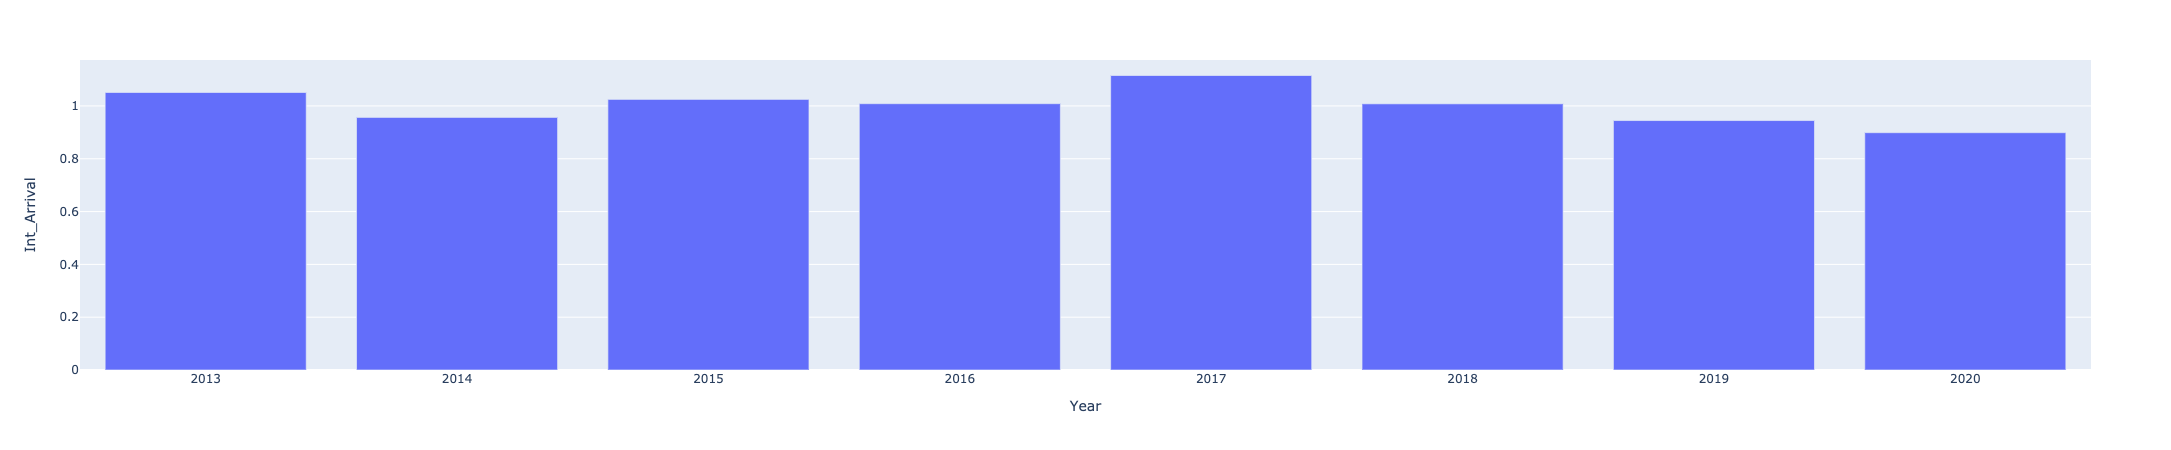

In [707]:
import plotly.express as px
fig = px.bar(annual_plot_df, x='Year', y='Int_Arrival')
fig.show()

In [709]:
arrivalsum_df.head(30)

Arrival_Probability
Event_Activity Day_Type Admission_Period Int_Arrival_Bins                     
High           Weekday  Planned          (0, 9]                       0.727599
                                         (9, 19]                      0.903226
                                         (19, 29]                     0.978495
                                         (29, 49]                     0.985663
                                         (49, 59]                     0.992832
                                         (59, 69]                     1.000000
                        Unplanned        (0, 9]                       0.701657
                                         (9, 19]                      0.944751
                                         (19, 29]                     0.977901
                                         (29, 49]                     1.000000
               Weekend  Planned          (0, 9]                       0.400000
                                         (9, 19]                      0.525000
                                         (19, 29]                     0.850000
                                         (29, 49]                     0.975000
                                         (49, 59]                     1.000000
                        Unplanned        (0, 9]                       0.333333
                                         (9, 19]                      0.833333
                                         (19, 29]                     0.958333
                                         (29, 49]                     1.000000
Low            Weekday  Planned          (0, 9]                       0.547368
                                         (9, 19]                      0.642105
                                         (19, 29]                     0.821053
                                         (29, 49]                     0.915789
                                         (49, 59]                     0.947368
                                         (59, 69]                     0.968421
                                         (69, 79]                     0.978947
                                         (79, 89]                     0.989474
                                         (89, 99]                     1.000000
                        Unplanned        (0, 9]                       0.428571
                                         (9, 19]                      0.761905

In [710]:
patientflowsum_df.head(30)

Next_Ward_Cum_Prob
Event_Activity Day_Type Admission_Period Prev_Flow Ward_Code                   
High           Weekday  Planned          IN        DS                  0.448763
                                                   ICU                 0.462898
                                                   MT                         1
                                         IN-DS     ICU                0.0444444
                                                   MT                         1
                                         IN-ICU    MT                         1
                        Unplanned        IN        DS                  0.227027
                                                   ICU                 0.232432
                                                   MT                         1
                                         IN-DS     MT                         1
                                         IN-ICU    MT                         1
               Weekend  Planned          IN        DS                     0.575
                                                   MT                         1
                                         IN-DS     MT                         1
                        Unplanned        IN        DS                  0.291667
                                                   ICU                 0.333333
                                                   MT                         1
                                         IN-DS     MT                         1
                                         IN-DS-ICU MT                         1
Low            Weekday  Planned          IN        DS                  0.402062
                                                   MT                         1
                                         IN-DS     MT                         1
                                         IN-MT     DS                         1
                        Unplanned        IN        DS                  0.309524
                                                   ICU                 0.333333
                                                   MT                         1
                                         IN-DS     ICU                0.0277778
                                                   MT                         1
                                         IN-ICU    MT                         1
               Weekend  Planned          IN        DS                       0.5

In [712]:
LOSsum_df.head(30)

LOS_Probability
Event_Activity Day_Type Admission_Period Prev_Flow Ward_Code LOS_Bins                   
High           Weekday  Planned          IN        DS        (0, 19]            0.393701
                                                             (19, 39]           0.905512
                                                             (39, 59]           0.992126
                                                             (59, 79]           1.000000
                                                   ICU       (0, 19]            1.250000
                                                             (19, 39]           1.500000
                                                             (39, 59]           2.000000
                                                   MT        (0, 19]            2.013158
                                                             (19, 39]           2.039474
                                                             (39, 59]           2.052632
                                                             (59, 79]           2.197368
                                                             (79, 99]           2.532895
                                                             (99, 119]          2.756579
                                                             (119, 139]         2.953947
                                                             (139, 159]         2.986842
                                                             (159, 179]         2.993421
                                                             (299, 319]         3.000000
                                         IN-DS     ICU       (39, 59]           4.000000
                                                   MT        (0, 19]            4.023256
                                                             (39, 59]           4.046512
                                                             (59, 79]           4.279070
                                                             (79, 99]           4.581395
                                                             (99, 119]          4.883721
                                                             (119, 139]         4.953488
                                                             (139, 159]         4.976744
                                                             (339, 359]         5.000000
                                         IN-ICU    MT        (19, 39]           5.500000
                                                             (159, 179]         6.000000
                        Unplanned        IN        DS        (0, 19]            0.357143
                                                             (19, 39]           0.976190

## SIMULATION CODE

In [706]:
import math

###### SEED DATA FOR SIMULATION
n_sims = 2
start_string = '01/01/2020'
finish_string = '12/11/2020'

arrival_df = arrivalsum_df
LOS_df = LOSsum_df
patientflow_df = patientflowsum_df
start = pd.Timestamp(start_string, unit='%d/%m/%Y %H:%M:%S')
finish = pd.Timestamp(finish_string, unit='%d/%m/%Y %H:%M:%S')


def next_arrival(df, event_activity, day_type, admission_period, from_year, from_month): 
    xp = pd.Series([0]).append(df.loc[event_activity, day_type, admission_period].iloc[:,0])
    fp = pd.Index([0]).append(df.loc[event_activity, day_type, admission_period].index.remove_unused_categories().categories.right)
    random_no = np.random.rand()
    result = np.interp(random_no, xp, fp) # Straight result based on Mean
    year_mod = year_mod_df.loc[year_mod_df.Year == from_year,'Int_Arrival'].iloc[0]
    month_mod = month_mod_df.loc[month_mod_df.Month == from_month,'Int_Arrival'].iloc[0]
    result_modified = result * year_mod * month_mod * 0.85 #APPARENT OVERALL MULTIPLIER
    return result_modified
#next_arrival(arrivalsum_df, 'High', 'Weekday', 'Planned', 2020, 'January')

def date_to_hierarcy(date_stamp):
    #date_stamp = pd.Timestamp(date_string, unit='%d/%m/%Y %H:%M:%S')
    #Extract time period
    hour_of_day = date_stamp.hour
    admission_period = timeconv['Admission_Period'][hour_of_day]
    #Extract type of day (i.e Weekday or Weekend)
    day_of_week = date_stamp.dayofweek
    day_type = dayconv['Day_Type'][day_of_week]
    #Extract Event based activity
    date_only = date_stamp.date()
    try: event = events_df.groupby('Date').Event.first().loc[date_only]
    except: event = 'NONE'
    event_index_no = event_activity['Event'].index(event)
    event_activity_level = event_activity['Event_Activity'][event_index_no]
    #Extract Month
    month = date_stamp.month_name()
    #Extract Year
    year = date_stamp.year
    return {'Admission_Period':admission_period, 'Day_Type':day_type, 'Event_Activity':event_activity_level,'Month':month, 'Year':year}
#date_to_hierarcy('25/12/2020 23:01:00')

def simulate_arrivals(df, n_sims, start, finish):
    results = {'Sim_No':[],'Arrival_Time':[]}
    current_timestamp = pd.Timestamp(start, unit='%d/%m/%Y')
    finish_timestamp = pd.Timestamp(finish, unit='%d/%m/%Y')
    for i in range(1, n_sims):
        while current_timestamp < finish_timestamp:
            hierarcy = date_to_hierarcy(current_timestamp)
            arrival_interval = round(next_arrival(df, hierarcy['Event_Activity'], hierarcy['Day_Type'], hierarcy['Admission_Period'], hierarcy['Year'], hierarcy['Month'])*60*60,0)
            try: current_timestamp += datetime.timedelta(seconds=arrival_interval) 
            except: print(arrival_interval)
            results['Sim_No'].append(i)
            results['Arrival_Time'].append(current_timestamp)
        current_timestamp = pd.Timestamp(start, unit='%d/%m/%Y')
        i += 1
    return results
#data = simulate_arrivals(arrivalsum_df, 10, '01/01/2017','02/01/2017')

def simulate_patient_flow(df, group_cat, prev_flow):
    ward_prob = df.loc[(group_cat['Event_Activity'], group_cat['Day_Type'], group_cat['Admission_Period'], prev_flow)]
    n = ward_prob.count().iloc[0]
    random_no = np.random.rand()
    for i in range(0, n):
        if random_no <= ward_prob.iloc[i,0]: 
            ward_code = ward_prob.index[i]
            break 
    return ward_code
#simulate_patient_flow(patientflow_df, date_to_hierarcy(start), 'IN')

def simulate_patient_LOS(df, group_cat, prev_flow, ward_code):
    xp = pd.Series([0]).append(df.loc[group_cat['Event_Activity'], group_cat['Day_Type'], group_cat['Admission_Period'], prev_flow, ward_code].iloc[:,0])
    fp = pd.Index([0]).append(df.loc[group_cat['Event_Activity'], group_cat['Day_Type'], group_cat['Admission_Period'], prev_flow, ward_code].index.remove_unused_categories().categories.right)
    #print (xp, fp)
    random_no = np.random.rand()
    result = datetime.timedelta(hours = np.interp(random_no, xp, fp))
    return result
#simulate_patient_LOS(LOS_df, date_to_hierarcy(start), 'IN', 'DS')

def run_simulation(n_sims, arrival_df, LOS_df, patientflow_df, start, finish):
    arrivals_data = simulate_arrivals(arrival_df, n_sims, start, finish)
    no_of_admissions = len(arrivals_data['Sim_No'])
    transfer_info = {'Sim_No':[],'Start':[],'Admit_id':[],'Prev_Flow':[],'Ward_Code':[],'LOS':[],'Patient_to_MT':[],'Patient_to_DS':[]}
    sim_no = 1
    for i in range(0, no_of_admissions):
        prev_flow, prev_ward = 'IN','IN'
        if sim_no != arrivals_data['Sim_No'][i]:
            sim_no = arrivals_data['Sim_No'][i]
        start = arrivals_data['Arrival_Time'][i]
        admit_id = i
        patient_discharged = False
        while patient_discharged == False:
            patient_to_MT, patient_to_DS = 0, 0
            group_categories = date_to_hierarcy(start)
            try: ward = simulate_patient_flow(patientflow_df, group_categories, prev_flow)
            except: 
                ward = 'OUT'
                patient_discharged = True
            try: LOS = simulate_patient_LOS(LOS_df, group_categories, prev_flow, ward)
            except: 
                ward = 'OUT'
                patient_discharged = True
            if ward == 'MT': 
                patient_to_MT = 1
            if ward == 'DS': 
                patient_to_DS = 1
            if prev_ward == 'MT': 
                patient_to_MT = -1
            if prev_ward == 'DS': 
                patient_to_DS = -1

            transfer_info['Sim_No'].append(sim_no)
            transfer_info['Start'].append(start)
            transfer_info['Admit_id'].append(admit_id)
            transfer_info['Prev_Flow'].append(prev_flow)
            transfer_info['Ward_Code'].append(ward)
            transfer_info['LOS'].append(LOS)
            transfer_info['Patient_to_MT'].append(patient_to_MT)
            transfer_info['Patient_to_DS'].append(patient_to_DS)

            #create new starting information
            start = start + LOS
            prev_flow = '-'.join((prev_flow, ward))
            prev_ward = ward
            #patient_discharged = True
                                 
    results_df = pd.DataFrame.from_dict(transfer_info)
    return results_df

sim2020_df = run_simulation(n_sims, arrival_df, LOS_df, patientflow_df, start, finish)

#%time run_simulation(n_sims, arrival_df, LOS_df, patientflow_df, start, finish)

## INTERPRETING RESULTS

In [705]:
df = sim2020_df
df = df.sort_values('Start')
df['MT_Occupancy'] = 0
df['MT_Occupancy'] = df.Patient_to_MT.cumsum()
df['DS_Occupancy'] = 0
df['DS_Occupancy'] = df.Patient_to_DS.cumsum()
#df = df.sort_values('Admit_id')
df

,Sim_No,Start,Admit_id,Prev_Flow,Ward_Code,LOS,Patient_to_MT,Patient_to_DS,MT_Occupancy,DS_Occupancy
0,1,2020-01-01 02:03:51.000000,0,IN,MT,25 days 07:58:54.401773,1,0,1,0
4,1,2020-01-01 13:23:00.000000,1,IN,MT,27 days 16:21:07.462789,1,0,2,0
10,1,2020-01-01 14:15:09.000000,2,IN,MT,8 days 18:18:31.341621,1,0,3,0
14,1,2020-01-01 20:47:54.000000,3,IN,DS,24 days 11:06:37.452030,0,1,3,1
19,1,2020-01-02 12:25:20.000000,4,IN,MT,1 days 13:05:13.152729,1,0,4,1
...,...,...,...,...,...,...,...,...,...,...
3629,1,2021-01-24 05:20:05.536155,872,IN-DS-MT-ICU-MT,OUT,1 days 14:23:17.348439,-1,0,2,0
3624,1,2021-02-01 06:56:54.100988,871,IN-DS-MT-ICU-MT,OUT,10 days 13:13:43.326428,-1,0,1,0
3421,1,2021-02-07 05:54:42.492639,823,IN-DS-MT,ICU,0 days 23:44:20.889861,-1,0,0,0
3422,1,2021-02-08 05:39:03.382500,823,IN-DS-MT-ICU,MT,10 days 10:22:46.340447,1,0,1,0


In [703]:
ideal_df.groupby('Year').describe()['Int_Arrival']

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2013,417.0,10.761703,11.435146,0.0,2.7200,6.820,15.0500,75.32
2014,892.0,9.795796,10.715812,0.0,2.2725,6.465,14.0050,73.42
2015,837.0,10.494552,11.281737,0.0,2.5800,7.170,14.7000,106.00
2016,850.0,10.327624,12.103679,0.0,2.0225,5.850,14.5000,90.50
2017,768.0,11.420260,13.385899,0.0,2.4725,7.325,15.5050,86.77
2018,848.0,10.322417,11.517116,0.0,2.5650,6.750,14.2925,93.03
2019,906.0,9.673709,11.754583,0.0,2.0000,6.280,12.5000,97.00
2020,551.0,9.202868,10.517994,0.0,1.9850,5.700,13.1400,86.68


## REPORTS

In [343]:
timeconv_df

,Admission_Period,Hour_of_Day
0,Planned,0
1,Unplanned,1
2,Unplanned,2
3,Unplanned,3
4,Unplanned,4
5,Planned,5
6,Planned,6
7,Planned,7
8,Planned,8
9,Unplanned,9


In [344]:
event_activity_df

,Event_Activity,Event
0,High,AFTERXMAS
1,High,B4EASTER
2,High,BEFOREXMAS
3,Low,EASTER
4,Normal,NONE
5,Normal,SCHOOL
6,Low,XMAS


In [345]:
dayconv_df

,Day_Type,Day
0,Weekday,0
1,Weekday,1
2,Weekday,2
3,Weekday,3
4,Weekday,4
5,Weekend,5
6,Weekend,6
